# Building your Own Activation Functions in CNNs: TaLU and ExLU
## Combining tanh and ReLU into "TaLU" and modifying ELU to have a continuous derivative
#### Dr John Hughes

This Notebook explores rolling your own Activation Functions as a means to improve Machine Learning results. To demonstrate the methodology two activations are built. The first, **TaLU**, is built by combining the well-known activation functions **tanh** and **ReLU**. The second, **ExLU** is a modifcation of the **ELU** Activation Function.

### Vizualization of ReLU, TaLU, Scaled TaLU and ExLU with shrinking and growing α values

<center><img src="assets/ReLU-TaLU-ExLU.jpg" alt="Talu" align="center" width="800"/></center>

### Some other Hybrid Activation Functions

Several research-backed activation functions follow similar hybrid patterns:

|Activation|Negative Side      |Positive Side|Notes                      |
|:---------|:------------------|:------------|:--------------------------|
|Leaky ReLU|αz (linear)        |z	        |Simple fix for dying ReLU  |
|ELU       |α(e<sup>z</sup> −1)|z            |Smooth and differentiable  |
|SELU      |Scaled ELU         |Scaled ELU   |Self-normalizing (λ used for scale)|
|Swish     |z . σ(z)           |-            |Learned activation (Google)|
|Mish      |z . tanh(ln(1+e<sup>z</sup>)) |-            |Smooth like Swish          |

Other functions include **GELU** (Gaussian Error Linear Unit) used in Transformers such as BERT and **SoftPlus** which is a smooth version of ReLU: **log(1+ex)**.

## SimpleNN and CNN for MNIST in PyTorch using ReLU, TaLU and ExLU

In [ ]:
# Ckeck GPU CUDA support
import torch, numpy, matplotlib
print("torch", torch.__version__, "| cuda:", torch.cuda.is_available())

In [ ]:
# Set up PyTorch environment

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import time

In [2]:
# Load and prepare MNIST dataset

# Define transformations for the images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with MNIST mean and std
])

# Load the training dataset
train_dataset = torchvision.datasets.MNIST(
    root='./Data',  # Where to store the dataset
    train=True,     # This is training data
    download=True,  # Download if not present
    transform=transform  # Apply transformations
)

# Load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./Data',
    train=False,
    download=True,
    transform=transform
)

# Create data loaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

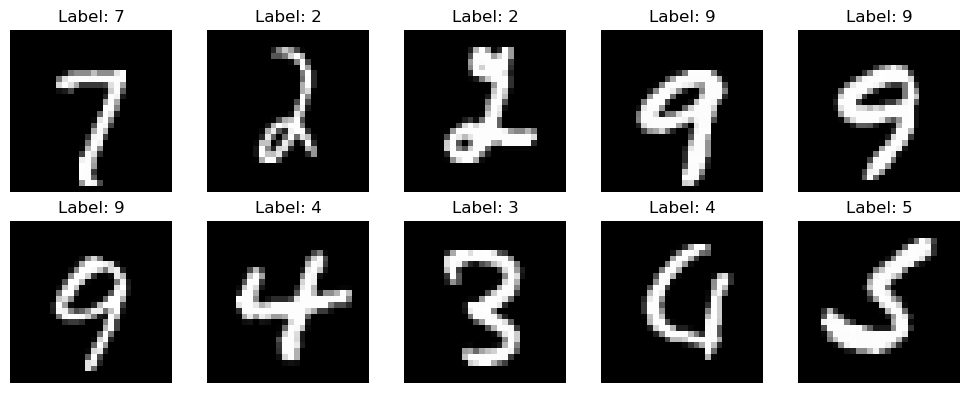

In [3]:
# Vizualize some of the MNIST images

# Function to display images
def show_images(images, labels):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    axes = axes.flatten()

    for i in range(10):
        axes[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
show_images(images[:10], labels[:10])

#### Sample MNIST images

<center><img src="assets/MNIST.jpg" alt="MNIST" align="center" width="800"/></center>

In [4]:
# Create simple neural network for classifying MNSIT digits: flatten layer + 3 dense linear layers all with ReLU activation

class SimpleNN_ReLU(nn.Module):
    def __init__(self):
        super(SimpleNN_ReLU, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Initialize the model
snn_ReLU_model = SimpleNN_ReLU()
print(snn_ReLU_model)

SimpleNN_ReLU(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [5]:
# Define Custom TaLU Activation fuction

class TaLU(nn.Module):
    def forward(self, x):
        return torch.where(x > 0, x, torch.tanh(x))

In [6]:
# Create simple neural network with custom "TaLU" Activation
    
class SimpleNN_TaLU(nn.Module):
    def __init__(self, activation):
        super(SimpleNN_TaLU, self).__init__()
        self.flatten = nn.Flatten()
        self.activation = activation                          ### Custom Activation
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activation(x)                                ### Apply TaLU after fc1
        x = self.fc2(x)
        x = self.activation(x)                                ### Apply TaLU after fc2
        x = self.fc3(x)
        return x

# Initialize the model with custom Activation
snn_TaLU_model = SimpleNN_TaLU(activation=TaLU())
print(snn_TaLU_model)

SimpleNN_TaLU(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation): TaLU()
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [7]:
# Define Custom TaLU Activation fuction that is scaled
class ScaledTaLU(nn.Module):
    def forward(self, x):
        scale = torch.exp(3 * x)
        tanh_scaled = torch.tanh(x) * scale
        return torch.where(x > 0, x, tanh_scaled)

In [8]:
# Create simple neural network with custom "ScaledTaLU" Activation
    
class SimpleNN_ScaledTaLU(nn.Module):
    def __init__(self, activation):
        super(SimpleNN_ScaledTaLU, self).__init__()
        self.flatten = nn.Flatten()
        self.activation = activation                          ### Custom Activation
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activation(x)                                ### Apply TaLU after fc1
        x = self.fc2(x)
        x = self.activation(x)                                ### Apply TaLU after fc2
        x = self.fc3(x)
        return x

# Initialize the model with custom Activation
snn_ScaledTaLU_model = SimpleNN_ScaledTaLU(activation=ScaledTaLU())
print(snn_ScaledTaLU_model)

SimpleNN_ScaledTaLU(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation): ScaledTaLU()
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [67]:
# Custom ExLU Activation with shrinkage or growth controlled by alpha
# Note this requires clamping or it can explode the network with NaNs!
# exp(-50) ≈ 1.928e-22 — small enough to be "virtually zero," but still numerically safe.

class ExLU(nn.Module):
    def __init__(self, alpha=1.0):
        super(ExLU, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        neg_branch = self.alpha * (torch.exp(torch.clamp(x / self.alpha, min=-50)) - 1)   # cap large exp values
        return torch.where(x >= 0, x, neg_branch)

In [10]:
# Create simple neural network with custom "ExLU" Activation                  ExLU
    
class SimpleNN_ExLU(nn.Module):
    def __init__(self, activation):
        super(SimpleNN_ExLU, self).__init__()
        self.flatten = nn.Flatten()
        self.activation = activation                          ### Custom Activation
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activation(x)                                ### Apply ExLU after fc1
        x = self.fc2(x)
        x = self.activation(x)                                ### Apply ExLU after fc2
        x = self.fc3(x)
        return x

# Initialize the model with custom Activation
snn_ExLU_model = SimpleNN_ExLU(activation=ExLU(alpha=0.2))
print(snn_ExLU_model)

SimpleNN_ExLU(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation): ExLU()
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


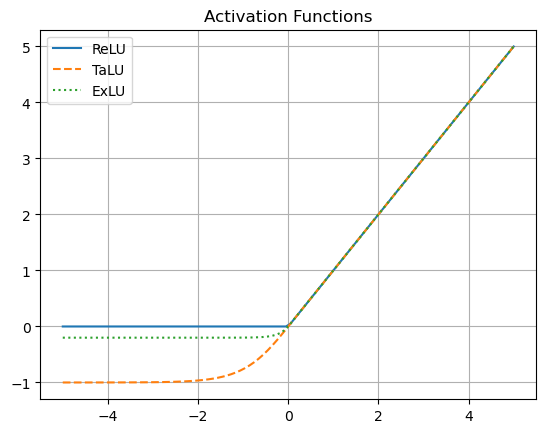

In [46]:
# Vizualize Activation Functions in PyTorch
x = torch.linspace(-5, 5, 100)
y_relu = torch.relu(x)
y_talu = torch.where(x > 0, x, torch.tanh(x))
alpha = 0.2                                                          # Update alpha to control EcLU shape
y_exlu = torch.where(x >= 0, x, alpha * (torch.exp(x / alpha) - 1))

plt.plot(x, y_relu, label='ReLU')
plt.plot(x, y_talu, label='TaLU', linestyle='--')
plt.plot(x, y_exlu, label='ExLU', linestyle=':')
plt.legend()
plt.title("Activation Functions")
plt.grid(True)
plt.show()

#### Compare Activation Functions

<center><img src="assets/Activation-Functions.jpg" alt="ReLU, TaLU, ExLU" align="center" width="520"/></center>

In [47]:
# Train the simple neural network with ReLU

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(snn_ReLU_model.parameters(), lr=0.01, momentum=0.9)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
snn_ReLU_model.to(device)

# Training loop
num_epochs = 5
snn_ReLU_train_losses = []

start = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = snn_ReLU_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            snn_ReLU_train_losses.append(running_loss/100)
            running_loss = 0.0

end = time.time()
print(f'SimpleNN ReLU training completed in {(end - start):.2f} seconds.') 

Using device: cuda:0
Epoch [1/5], Step [100/938], Loss: 1.0935
Epoch [1/5], Step [200/938], Loss: 0.3985
Epoch [1/5], Step [300/938], Loss: 0.2897
Epoch [1/5], Step [400/938], Loss: 0.2442
Epoch [1/5], Step [500/938], Loss: 0.2342
Epoch [1/5], Step [600/938], Loss: 0.1868
Epoch [1/5], Step [700/938], Loss: 0.1832
Epoch [1/5], Step [800/938], Loss: 0.1638
Epoch [1/5], Step [900/938], Loss: 0.1542
Epoch [2/5], Step [100/938], Loss: 0.1252
Epoch [2/5], Step [200/938], Loss: 0.1293
Epoch [2/5], Step [300/938], Loss: 0.1196
Epoch [2/5], Step [400/938], Loss: 0.1213
Epoch [2/5], Step [500/938], Loss: 0.1275
Epoch [2/5], Step [600/938], Loss: 0.1183
Epoch [2/5], Step [700/938], Loss: 0.0967
Epoch [2/5], Step [800/938], Loss: 0.1116
Epoch [2/5], Step [900/938], Loss: 0.0959
Epoch [3/5], Step [100/938], Loss: 0.0747
Epoch [3/5], Step [200/938], Loss: 0.0808
Epoch [3/5], Step [300/938], Loss: 0.0806
Epoch [3/5], Step [400/938], Loss: 0.0795
Epoch [3/5], Step [500/938], Loss: 0.0784
Epoch [3/5], 

In [48]:
# Train the simple neural network with custom TaLU Activation

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(snn_TaLU_model.parameters(), lr=0.01, momentum=0.9)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
snn_TaLU_model.to(device)

# Training loop
num_epochs = 5
snn_TaLU_train_losses = []

start = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = snn_TaLU_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            snn_TaLU_train_losses.append(running_loss/100)
            running_loss = 0.0

end = time.time()
print(f'SimpleNN TaLU training completed in {(end - start):.2f} seconds.') 

Using device: cuda:0
Epoch [1/5], Step [100/938], Loss: 0.8208
Epoch [1/5], Step [200/938], Loss: 0.3602
Epoch [1/5], Step [300/938], Loss: 0.3003
Epoch [1/5], Step [400/938], Loss: 0.2603
Epoch [1/5], Step [500/938], Loss: 0.2349
Epoch [1/5], Step [600/938], Loss: 0.2298
Epoch [1/5], Step [700/938], Loss: 0.2046
Epoch [1/5], Step [800/938], Loss: 0.1747
Epoch [1/5], Step [900/938], Loss: 0.1600
Epoch [2/5], Step [100/938], Loss: 0.1289
Epoch [2/5], Step [200/938], Loss: 0.1376
Epoch [2/5], Step [300/938], Loss: 0.1366
Epoch [2/5], Step [400/938], Loss: 0.1318
Epoch [2/5], Step [500/938], Loss: 0.1248
Epoch [2/5], Step [600/938], Loss: 0.1132
Epoch [2/5], Step [700/938], Loss: 0.1129
Epoch [2/5], Step [800/938], Loss: 0.1134
Epoch [2/5], Step [900/938], Loss: 0.1106
Epoch [3/5], Step [100/938], Loss: 0.0854
Epoch [3/5], Step [200/938], Loss: 0.0829
Epoch [3/5], Step [300/938], Loss: 0.0809
Epoch [3/5], Step [400/938], Loss: 0.0829
Epoch [3/5], Step [500/938], Loss: 0.0834
Epoch [3/5], 

In [49]:
# Train the simple neural network with custom Scaled TaLU Activation

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(snn_ScaledTaLU_model.parameters(), lr=0.01, momentum=0.9)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
snn_ScaledTaLU_model.to(device)

# Training loop
num_epochs = 5
snn_ScaledTaLU_train_losses = []

start = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = snn_ScaledTaLU_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            snn_ScaledTaLU_train_losses.append(running_loss/100)
            running_loss = 0.0

end = time.time()
print(f'SimpleNN Scaled TaLU training completed in {(end - start):.2f} seconds.') 

Using device: cuda:0
Epoch [1/5], Step [100/938], Loss: 1.0040
Epoch [1/5], Step [200/938], Loss: 0.3607
Epoch [1/5], Step [300/938], Loss: 0.2976
Epoch [1/5], Step [400/938], Loss: 0.2416
Epoch [1/5], Step [500/938], Loss: 0.2263
Epoch [1/5], Step [600/938], Loss: 0.2208
Epoch [1/5], Step [700/938], Loss: 0.1842
Epoch [1/5], Step [800/938], Loss: 0.1863
Epoch [1/5], Step [900/938], Loss: 0.1524
Epoch [2/5], Step [100/938], Loss: 0.1334
Epoch [2/5], Step [200/938], Loss: 0.1207
Epoch [2/5], Step [300/938], Loss: 0.1252
Epoch [2/5], Step [400/938], Loss: 0.1126
Epoch [2/5], Step [500/938], Loss: 0.1129
Epoch [2/5], Step [600/938], Loss: 0.1033
Epoch [2/5], Step [700/938], Loss: 0.1136
Epoch [2/5], Step [800/938], Loss: 0.0965
Epoch [2/5], Step [900/938], Loss: 0.0978
Epoch [3/5], Step [100/938], Loss: 0.0753
Epoch [3/5], Step [200/938], Loss: 0.0780
Epoch [3/5], Step [300/938], Loss: 0.0759
Epoch [3/5], Step [400/938], Loss: 0.0728
Epoch [3/5], Step [500/938], Loss: 0.0747
Epoch [3/5], 

In [50]:
# Train the simple neural network with custom ExLU Activation

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(snn_ExLU_model.parameters(), lr=0.01, momentum=0.9)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
snn_ExLU_model.to(device)

# Training loop
num_epochs = 5
snn_ExLU_train_losses = []

start = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = snn_ExLU_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            snn_ExLU_train_losses.append(running_loss/100)
            running_loss = 0.0

end = time.time()
print(f'SimpleNN ExLU training completed in {(end - start):.2f} seconds.') 

Using device: cuda:0
Epoch [1/5], Step [100/938], Loss: 1.0270
Epoch [1/5], Step [200/938], Loss: 0.3707
Epoch [1/5], Step [300/938], Loss: 0.2871
Epoch [1/5], Step [400/938], Loss: 0.2570
Epoch [1/5], Step [500/938], Loss: 0.2431
Epoch [1/5], Step [600/938], Loss: 0.2013
Epoch [1/5], Step [700/938], Loss: 0.1831
Epoch [1/5], Step [800/938], Loss: 0.1670
Epoch [1/5], Step [900/938], Loss: 0.1657
Epoch [2/5], Step [100/938], Loss: 0.1368
Epoch [2/5], Step [200/938], Loss: 0.1325
Epoch [2/5], Step [300/938], Loss: 0.1147
Epoch [2/5], Step [400/938], Loss: 0.1001
Epoch [2/5], Step [500/938], Loss: 0.1206
Epoch [2/5], Step [600/938], Loss: 0.1010
Epoch [2/5], Step [700/938], Loss: 0.1029
Epoch [2/5], Step [800/938], Loss: 0.1031
Epoch [2/5], Step [900/938], Loss: 0.0990
Epoch [3/5], Step [100/938], Loss: 0.0785
Epoch [3/5], Step [200/938], Loss: 0.0745
Epoch [3/5], Step [300/938], Loss: 0.0760
Epoch [3/5], Step [400/938], Loss: 0.0755
Epoch [3/5], Step [500/938], Loss: 0.0727
Epoch [3/5], 

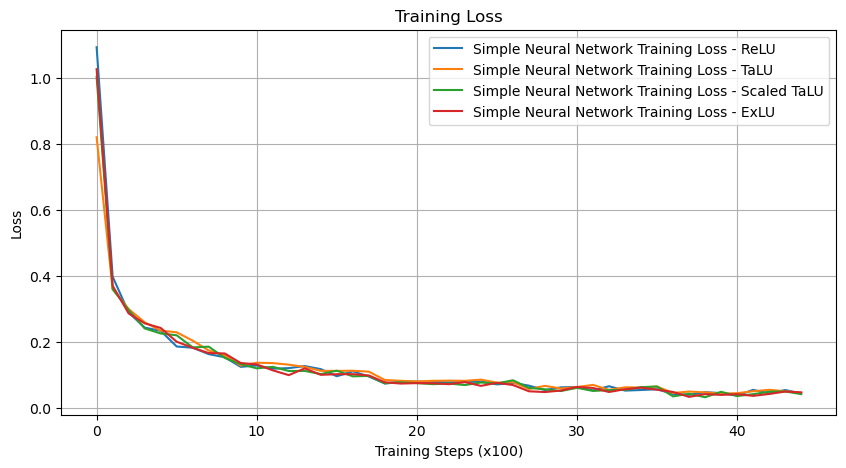

In [51]:
# Vizualize the simple neural network training process by plotting the loss and compare ReLU, TaLU and ExLU

plt.figure(figsize=(10, 5))
plt.plot(snn_ReLU_train_losses, label='Simple Neural Network Training Loss - ReLU')
plt.plot(snn_TaLU_train_losses, label='Simple Neural Network Training Loss - TaLU')
plt.plot(snn_ScaledTaLU_train_losses, label='Simple Neural Network Training Loss - Scaled TaLU')
plt.plot(snn_ExLU_train_losses, label='Simple Neural Network Training Loss - ExLU')
plt.title('Training Loss')
plt.xlabel('Training Steps (x100)')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

#### Compare Training Loss for Activation Functions

<center><img src="assets/Training-Loss.jpg" alt="Training Loss: ReLU, TaLU, ExLU" align="center" width="720"/></center>

The training loss for ReLU, TaLU, Scaled TaLU and ExLU are very similar.

In [53]:
# Evaluate the models to see how well they perfrom on unseen data

# Evaluate the ReLU model
snn_ReLU_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = snn_ReLU_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'SimpleNN ReLU Correct: {correct} out of {total}.')
print(f'SimpleNN ReLU Accuracy on the test set: {accuracy:.2f}%\n')

# Evaluate the TaLU model
snn_TaLU_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = snn_TaLU_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'SimpleNN TaLU Correct: {correct} out of {total}.')
print(f'SimpleNN TaLU Accuracy on the test set: {accuracy:.2f}%\n')

# Evaluate the Scaled TaLU model
snn_ScaledTaLU_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = snn_ScaledTaLU_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'SimpleNN Scaled TaLU Correct: {correct} out of {total}.')
print(f'SimpleNN Scaled TaLU Accuracy on the test set: {accuracy:.2f}%\n')

# Evaluate the ExLU model
snn_ExLU_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = snn_ExLU_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'SimpleNN ExLU Correct: {correct} out of {total}.')
print(f'SimpleNN ExLU Accuracy on the test set: {accuracy:.2f}%')

SimpleNN ReLU Correct: 9765 out of 10000.
SimpleNN ReLU Accuracy on the test set: 97.65%

SimpleNN TaLU Correct: 9752 out of 10000.
SimpleNN TaLU Accuracy on the test set: 97.52%

SimpleNN Scaled TaLU Correct: 9751 out of 10000.
SimpleNN Scaled TaLU Accuracy on the test set: 97.51%

SimpleNN ExLU Correct: 9778 out of 10000.
SimpleNN ExLU Accuracy on the test set: 97.78%



ReLU


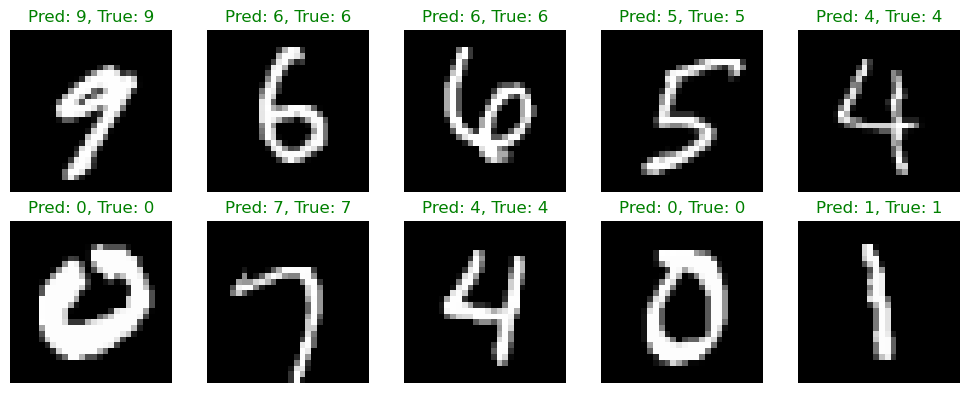


TaLU


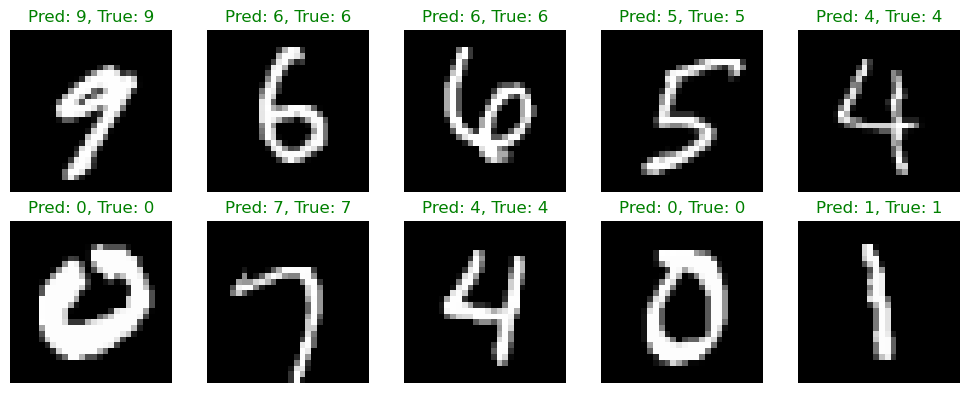


ExLU


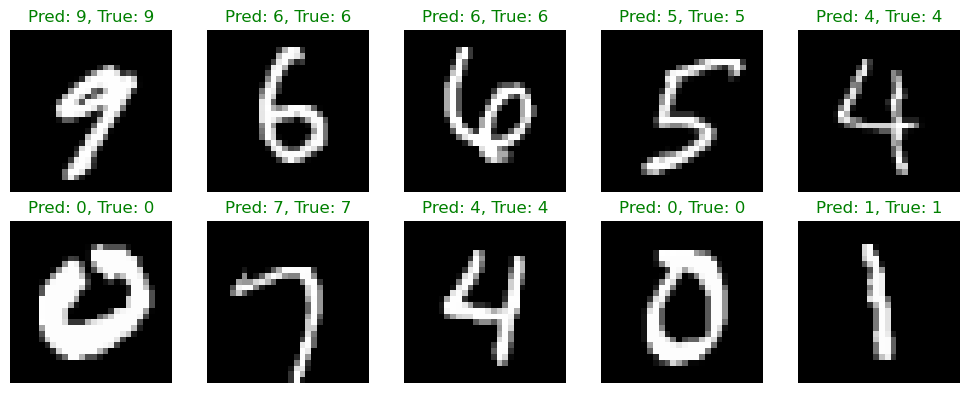

In [54]:
# Vizualize some predictions to see how our model is doing

# Function to show predictions
def show_predictions(images, labels, preds):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    axes = axes.flatten()

    for i in range(10):
        axes[i].imshow(images[i].cpu().reshape(28, 28), cmap='gray')
        color = 'green' if preds[i] == labels[i] else 'red'
        axes[i].set_title(f"Pred: {preds[i]}, True: {labels[i]}", color=color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Get predictions for some test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Show Simple Neural Network with ReLU predictions
outputs = snn_ReLU_model(images)
_, preds = torch.max(outputs, 1)

pred_start=20                                  # Adjust to show different range of numbers

# Show ReLU predictions
print("\nReLU")
show_predictions(images[pred_start:pred_start+10], labels[pred_start:pred_start+10], preds[pred_start:pred_start+10])

# Show Simple Neural Network with TaLU predictions
outputs = snn_TaLU_model(images)
_, preds = torch.max(outputs, 1)

# Show TaLU predictions
print("\nTaLU")
show_predictions(images[pred_start:pred_start+10], labels[pred_start:pred_start+10], preds[pred_start:pred_start+10])

# Show Simple Neural Network with ExLU predictions
outputs = snn_ExLU_model(images)
_, preds = torch.max(outputs, 1)

# Show ExLU predictions
print("\nExLU")
show_predictions(images[pred_start:pred_start+10], labels[pred_start:pred_start+10], preds[pred_start:pred_start+10])

#### Vizualize some predictions to see how our model is doing

<center><img src="assets/Predictions.jpg" alt="Simple Neural Network ReLU vs TaLU: Predictions" align="center" width="800"/></center>

This run shows one misclassified numeral.

In [ ]:
# Save and load a model so it can be used it later without retraining

# Save the model
torch.save(snn_ReLU_model.state_dict(), 'mnist_snn_ReLU_model.pth')
print("Model saved!")

# Load the model (for future use)
loaded_model = SimpleNN_ReLU()
loaded_model.load_state_dict(torch.load('mnist_snn_ReLU_model.pth'))
loaded_model.to(device)
loaded_model.eval()
print("Model loaded!")

In [79]:
# Use a Convolutional Neural Network (CNN) to see if we can improve performance 

# While the simple neural network works reasonably well, CNNs are typically better for image processing tasks 

class CNN_ReLU(nn.Module):
    def __init__(self):
        super(CNN_ReLU, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the CNN model
cnn_ReLU_model = CNN_ReLU().to(device)
print(cnn_ReLU_model)

CNN_ReLU(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [80]:
# Create similar Convolutional Neural Network with custom "TaLU" Activation

class CNN_TaLU(nn.Module):
    def __init__(self, activation):
        super(CNN_TaLU, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.activation = activation                              ### Custom Activation
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)                                    ### Apply TaLU
        x = self.pool(x)
        x = self.conv2(x)
        x = x = self.activation(x)                                ### Apply TaLU
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = self.activation(x)                                    ### Apply TaLU
        x = self.fc2(x)
        return x

# Initialize the CNN model
cnn_TaLU_model = CNN_TaLU(activation=TaLU()).to(device)
print(cnn_TaLU_model)

CNN_TaLU(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation): TaLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [81]:
# Create similar Convolutional Neural Network with custom "ExLU" Activation

class CNN_ExLU(nn.Module):
    def __init__(self, activation):
        super(CNN_ExLU, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.activation = activation                            ### Custom Activation
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)                                  ### Apply ExLU
        x = self.pool(x)
        x = self.conv2(x)
        x = self.activation(x)                                  ### Apply ExLU
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = self.activation(x)                                  ### Apply ExLU
        x = self.fc2(x)
        return x

# Initialize the CNN model
cnn_ExLU_model = CNN_ExLU(activation=ExLU(alpha=0.2)).to(device)
print(cnn_ExLU_model)

CNN_ExLU(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation): ExLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [58]:
# Train the CNN with RelU (code is very similar to simple neural network training step above)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_ReLU_model.parameters(), lr=0.01, momentum=0.9)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
cnn_ReLU_model.to(device)

# Training loop
num_epochs = 5
cnn_ReLU_train_losses = []

start = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = cnn_ReLU_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            cnn_ReLU_train_losses.append(running_loss/100)
            running_loss = 0.0

end = time.time()
print(f'CNN ReLU training completed in {(end - start):.2f} seconds.') 

Using device: cuda:0
Epoch [1/5], Step [100/938], Loss: 0.8754
Epoch [1/5], Step [200/938], Loss: 0.2002
Epoch [1/5], Step [300/938], Loss: 0.1395
Epoch [1/5], Step [400/938], Loss: 0.1066
Epoch [1/5], Step [500/938], Loss: 0.0970
Epoch [1/5], Step [600/938], Loss: 0.0917
Epoch [1/5], Step [700/938], Loss: 0.0813
Epoch [1/5], Step [800/938], Loss: 0.0885
Epoch [1/5], Step [900/938], Loss: 0.0607
Epoch [2/5], Step [100/938], Loss: 0.0444
Epoch [2/5], Step [200/938], Loss: 0.0621
Epoch [2/5], Step [300/938], Loss: 0.0549
Epoch [2/5], Step [400/938], Loss: 0.0508
Epoch [2/5], Step [500/938], Loss: 0.0412
Epoch [2/5], Step [600/938], Loss: 0.0431
Epoch [2/5], Step [700/938], Loss: 0.0469
Epoch [2/5], Step [800/938], Loss: 0.0475
Epoch [2/5], Step [900/938], Loss: 0.0379
Epoch [3/5], Step [100/938], Loss: 0.0365
Epoch [3/5], Step [200/938], Loss: 0.0243
Epoch [3/5], Step [300/938], Loss: 0.0406
Epoch [3/5], Step [400/938], Loss: 0.0358
Epoch [3/5], Step [500/938], Loss: 0.0272
Epoch [3/5], 

In [60]:
# Train the CNN with TalU

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_TaLU_model.parameters(), lr=0.01, momentum=0.9)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
cnn_TaLU_model.to(device)

# Training loop
num_epochs = 5
cnn_TaLU_train_losses = []

start = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = cnn_TaLU_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            cnn_TaLU_train_losses.append(running_loss/100.0)
            running_loss = 0.0

end = time.time()
print(f'CNN TaLU training completed in {(end - start):.2f} seconds.') 

Using device: cuda:0
Epoch [1/5], Step [100/938], Loss: 0.7297
Epoch [1/5], Step [200/938], Loss: 0.1737
Epoch [1/5], Step [300/938], Loss: 0.1281
Epoch [1/5], Step [400/938], Loss: 0.1145
Epoch [1/5], Step [500/938], Loss: 0.0959
Epoch [1/5], Step [600/938], Loss: 0.0872
Epoch [1/5], Step [700/938], Loss: 0.0832
Epoch [1/5], Step [800/938], Loss: 0.0753
Epoch [1/5], Step [900/938], Loss: 0.0547
Epoch [2/5], Step [100/938], Loss: 0.0474
Epoch [2/5], Step [200/938], Loss: 0.0512
Epoch [2/5], Step [300/938], Loss: 0.0463
Epoch [2/5], Step [400/938], Loss: 0.0568
Epoch [2/5], Step [500/938], Loss: 0.0458
Epoch [2/5], Step [600/938], Loss: 0.0440
Epoch [2/5], Step [700/938], Loss: 0.0414
Epoch [2/5], Step [800/938], Loss: 0.0385
Epoch [2/5], Step [900/938], Loss: 0.0431
Epoch [3/5], Step [100/938], Loss: 0.0290
Epoch [3/5], Step [200/938], Loss: 0.0291
Epoch [3/5], Step [300/938], Loss: 0.0284
Epoch [3/5], Step [400/938], Loss: 0.0362
Epoch [3/5], Step [500/938], Loss: 0.0334
Epoch [3/5], 

In [70]:
# Train the CNN with ExlU

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_ExLU_model.parameters(), lr=0.01, momentum=0.9)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
cnn_ExLU_model.to(device)

# Training loop
num_epochs = 5
cnn_ExLU_train_losses = []

start = time.time()

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = cnn_ExLU_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            cnn_ExLU_train_losses.append(running_loss/100)
            running_loss = 0.0

end = time.time()
print(f'CNN ExLU training completed in {(end - start):.2f} seconds.') 

Using device: cuda:0
Epoch [1/5], Step [100/938], Loss: 0.8199
Epoch [1/5], Step [200/938], Loss: 0.1790
Epoch [1/5], Step [300/938], Loss: 0.1255
Epoch [1/5], Step [400/938], Loss: 0.1029
Epoch [1/5], Step [500/938], Loss: 0.0844
Epoch [1/5], Step [600/938], Loss: 0.0755
Epoch [1/5], Step [700/938], Loss: 0.0812
Epoch [1/5], Step [800/938], Loss: 0.0587
Epoch [1/5], Step [900/938], Loss: 0.0675
Epoch [2/5], Step [100/938], Loss: 0.0442
Epoch [2/5], Step [200/938], Loss: 0.0482
Epoch [2/5], Step [300/938], Loss: 0.0433
Epoch [2/5], Step [400/938], Loss: 0.0473
Epoch [2/5], Step [500/938], Loss: 0.0424
Epoch [2/5], Step [600/938], Loss: 0.0472
Epoch [2/5], Step [700/938], Loss: 0.0350
Epoch [2/5], Step [800/938], Loss: 0.0457
Epoch [2/5], Step [900/938], Loss: 0.0441
Epoch [3/5], Step [100/938], Loss: 0.0343
Epoch [3/5], Step [200/938], Loss: 0.0323
Epoch [3/5], Step [300/938], Loss: 0.0338
Epoch [3/5], Step [400/938], Loss: 0.0290
Epoch [3/5], Step [500/938], Loss: 0.0284
Epoch [3/5], 

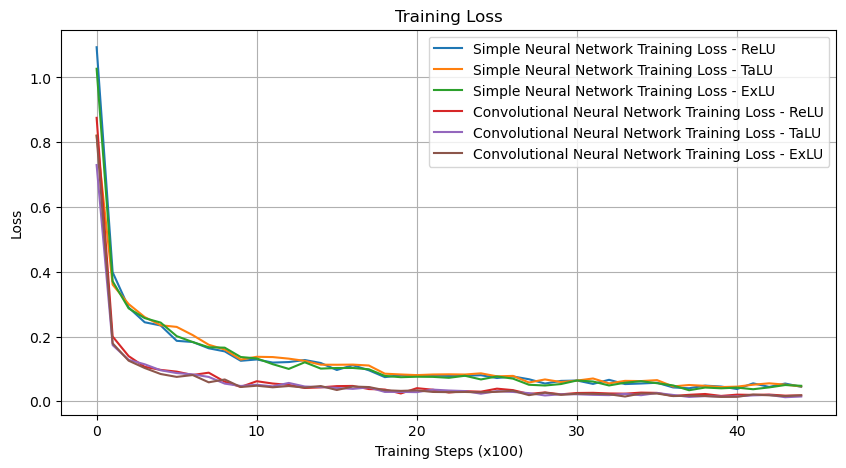

In [71]:
# Vizualize all models and loss functions together

plt.figure(figsize=(10, 5))
plt.plot(snn_ReLU_train_losses, label='Simple Neural Network Training Loss - ReLU')
plt.plot(snn_TaLU_train_losses, label='Simple Neural Network Training Loss - TaLU')
plt.plot(snn_ExLU_train_losses, label='Simple Neural Network Training Loss - ExLU')
plt.plot(cnn_ReLU_train_losses, label='Convolutional Neural Network Training Loss - ReLU')
plt.plot(cnn_TaLU_train_losses, label='Convolutional Neural Network Training Loss - TaLU')
plt.plot(cnn_ExLU_train_losses, label='Convolutional Neural Network Training Loss - ExLU')
plt.title('Training Loss')
plt.xlabel('Training Steps (x100)')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

#### Vizualize all models and loss functions together

<center><img src="assets/ReLU-TaLU-ExLU-Vizualization.jpg" alt="Simple Neural Network and CNN: ReLU vs TaLU vs ExLU Vizualization" align="center" width="720"/></center>

Again, results for ReLU, TaLU and ExLU are very similar for Simple Neural Networks and Convolutional Neural Networks.

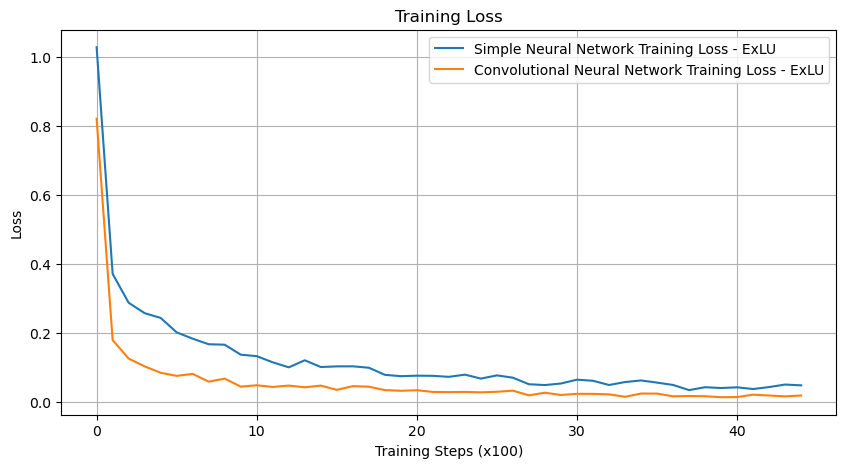

In [72]:
# Vizualize single fuction SimpleNN vs CNN

plt.figure(figsize=(10, 5))
plt.plot(snn_ExLU_train_losses, label='Simple Neural Network Training Loss - ExLU')
plt.plot(cnn_ExLU_train_losses, label='Convolutional Neural Network Training Loss - ExLU')
plt.title('Training Loss')
plt.xlabel('Training Steps (x100)')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

#### Vizualize single fuction SimpleNN vs CNN

<center><img src="assets/ExLU-Vizualization.jpg" alt="Simple Neural Network and CNN: ExLU - Vizualization" align="center" width="720"/></center>

In [73]:
# Evaluate all models to see how well they perfrom on unseen data

# Evaluate the SimpleNN ReLU model
snn_ReLU_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = snn_ReLU_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'SimpleNN ReLU Correct: {correct} out of {total}.')
print(f'SimpleNN ReLU Accuracy on the test set: {accuracy:.2f}%\n')

# Evaluate the SimpleNN TaLU model
snn_TaLU_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = snn_TaLU_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'SimpleNN TaLU Correct: {correct} out of {total}.')
print(f'SimpleNN TaLU Accuracy on the test set: {accuracy:.2f}%\n')


# Evaluate the ExLU model
snn_ExLU_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = snn_ExLU_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'SimpleNN ExLU Correct: {correct} out of {total}.')
print(f'SimpleNN ExLU Accuracy on the test set: {accuracy:.2f}%\n')

# Evaluate the CNN ReLU model
cnn_ReLU_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_ReLU_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'CNN ReLU Correct: {correct} out of {total}.')
print(f'CNN ReLU Accuracy on the test set: {accuracy:.2f}%\n')

# Evaluate the CNN TaLU model
cnn_TaLU_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_TaLU_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'CNN TaLU Correct: {correct} out of {total}.')
print(f'CNN TaLU Accuracy on the test set: {accuracy:.2f}%\n')

# Evaluate the CNN ExLU model
cnn_ExLU_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_ExLU_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'CNN ExLU Correct: {correct} out of {total}.')
print(f'CNN ExLU Accuracy on the test set: {accuracy:.2f}%')

SimpleNN ReLU Correct: 9765 out of 10000.
SimpleNN ReLU Accuracy on the test set: 97.65%

SimpleNN TaLU Correct: 9752 out of 10000.
SimpleNN TaLU Accuracy on the test set: 97.52%

SimpleNN ExLU Correct: 9778 out of 10000.
SimpleNN ExLU Accuracy on the test set: 97.78%

CNN ReLU Correct: 9911 out of 10000.
CNN ReLU Accuracy on the test set: 99.11%

CNN TaLU Correct: 9924 out of 10000.
CNN TaLU Accuracy on the test set: 99.24%

CNN ExLU Correct: 9909 out of 10000.
CNN ExLU Accuracy on the test set: 99.09%


# Now to run the models on the CIFAR-10 dataset
The MNIST results didn't show much difference between Activation Functions so testing on a larger dataset may help differentiate them.

In [102]:
# Load and prepare CIFAR-10 dataset

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./Data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./Data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


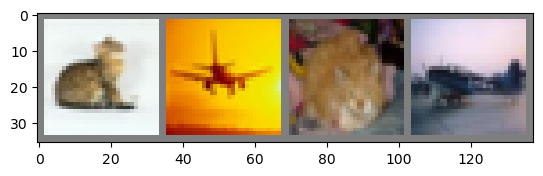

cat   plane cat   plane


In [103]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


    # get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [104]:
# Apply a Convolutional Neural Network (CNN) using ReLU on 3 channels

import torch.nn as nn
import torch.nn.functional as F

class Net_ReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)                   # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the CNN model
Net_ReLU_model = Net_ReLU().to(device)
print(Net_ReLU_model)

Net_ReLU(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [105]:
# ReLU Optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
ReLUoptimizer = optim.SGD(Net_ReLU_model.parameters(), lr=0.001, momentum=0.9)

In [131]:
# Use CNN ReLU for CIFAR-10 which also uses 10 outputs

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
Net_ReLU_model.to(device)

# Training loop
Net_ReLU_train_losses = []

start = time.time()

for epoch in range(12):                                   # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)          # <-- MOVE TO GPU

        # zero the parameter gradients
        ReLUoptimizer.zero_grad()

        # forward + backward + optimize
        outputs = Net_ReLU_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        ReLUoptimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            Net_ReLU_train_losses.append(running_loss/100)
            running_loss = 0.0


end = time.time()
print(f'CNN ReLU training for CIFAR-10 completed in {(end - start):.2f} seconds.') 

Using device: cuda:0
[1,  2000] loss: 1.228
[1,  4000] loss: 1.211
[1,  6000] loss: 1.224
[1,  8000] loss: 1.216
[1, 10000] loss: 1.218
[1, 12000] loss: 1.196
[2,  2000] loss: 1.104
[2,  4000] loss: 1.135
[2,  6000] loss: 1.105
[2,  8000] loss: 1.129
[2, 10000] loss: 1.133
[2, 12000] loss: 1.120
[3,  2000] loss: 1.054
[3,  4000] loss: 1.047
[3,  6000] loss: 1.081
[3,  8000] loss: 1.037
[3, 10000] loss: 1.069
[3, 12000] loss: 1.047
[4,  2000] loss: 0.975
[4,  4000] loss: 0.991
[4,  6000] loss: 1.002
[4,  8000] loss: 0.994
[4, 10000] loss: 1.034
[4, 12000] loss: 1.009
[5,  2000] loss: 0.906
[5,  4000] loss: 0.934
[5,  6000] loss: 0.962
[5,  8000] loss: 0.965
[5, 10000] loss: 0.963
[5, 12000] loss: 0.980
[6,  2000] loss: 0.880
[6,  4000] loss: 0.894
[6,  6000] loss: 0.891
[6,  8000] loss: 0.929
[6, 10000] loss: 0.918
[6, 12000] loss: 0.951
[7,  2000] loss: 0.851
[7,  4000] loss: 0.842
[7,  6000] loss: 0.876
[7,  8000] loss: 0.904
[7, 10000] loss: 0.888
[7, 12000] loss: 0.903
[8,  2000] lo

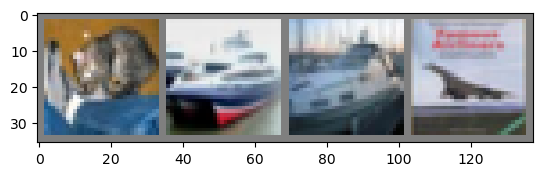

GroundTruth:  cat   ship  ship  plane


In [132]:
# Examine data

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [133]:
# Check to see what these images are predicted to be by the network

images = images.to(device)                 # <-- MOVE TO GPU
outputs = Net_ReLU_model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  deer  ship  car   plane


In [134]:
# Test accuracy of ReLU CNN

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)          # <-- MOVE TO GPU
        # calculate outputs by running images through the network
        outputs = Net_ReLU_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %


In [135]:
# Check which classes performed best for ReLU

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)          # <-- MOVE TO GPU
        outputs = Net_ReLU_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
print("CNN ReLU class results\n")
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 61.3 %
Accuracy for class: car   is 74.8 %
Accuracy for class: bird  is 51.4 %
Accuracy for class: cat   is 47.7 %
Accuracy for class: deer  is 48.0 %
Accuracy for class: dog   is 55.6 %
Accuracy for class: frog  is 70.7 %
Accuracy for class: horse is 66.0 %
Accuracy for class: ship  is 74.8 %
Accuracy for class: truck is 72.5 %


In [149]:
# Apply a Convolutional Neural Network (CNN) using TaLU on 3 channels

import torch.nn as nn
import torch.nn.functional as F

class Net_TaLU(nn.Module):
    def __init__(self, activation):
        super(Net_TaLU, self).__init__()
        self.activation = activation                              ### Custom Activation
        self.conv1 = nn.Conv2d(3, 6, 5)                           # output: (6, 28, 28) 
        self.pool = nn.MaxPool2d(2, 2)                            # output: (6, 14, 14)
        self.conv2 = nn.Conv2d(6, 16, 5)                          # output: (16, 10, 10) -> pool -> (16, 5, 5)

        # Compute the flattened feature size dynamically
        self._to_linear = None
        self._get_flattened_size()
        
        self.fc1 = nn.Linear(self._to_linear, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 3, 32, 32)
            x = self.pool(self.activation(self.conv1(x)))
            x = self.pool(self.activation(self.conv2(x)))
            self._to_linear = x.numel()
            
    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = x.view(x.size(0), -1)  # flatten
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the CNN model
Net_TaLU_model = Net_TaLU(activation=TaLU()).to(device)
print(Net_TaLU_model)

Net_TaLU(
  (activation): TaLU()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [153]:
# TaLU Optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
TaLUoptimizer = optim.SGD(Net_TaLU_model.parameters(), lr=0.001, momentum=0.9)

In [154]:
# Use CNN ReLU for CIFAR-10 which also uses 10 outputs

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
Net_TaLU_model.to(device)

# Training loop
Net_TaLU_train_losses = []

start = time.time()

for epoch in range(12):                                   # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)          # <-- MOVE TO GPU

        # zero the parameter gradients
        TaLUoptimizer.zero_grad()

        # forward + backward + optimize
        outputs = Net_TaLU_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        TaLUoptimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            Net_TaLU_train_losses.append(running_loss/100)
            running_loss = 0.0


end = time.time()
print(f'CNN TaLU training for CIFAR-10 completed in {(end - start):.2f} seconds.') 

Using device: cuda:0
[1,  2000] loss: 1.974
[1,  4000] loss: 1.611
[1,  6000] loss: 1.498
[1,  8000] loss: 1.446
[1, 10000] loss: 1.364
[1, 12000] loss: 1.343
[2,  2000] loss: 1.277
[2,  4000] loss: 1.251
[2,  6000] loss: 1.236
[2,  8000] loss: 1.221
[2, 10000] loss: 1.204
[2, 12000] loss: 1.174
[3,  2000] loss: 1.118
[3,  4000] loss: 1.102
[3,  6000] loss: 1.114
[3,  8000] loss: 1.102
[3, 10000] loss: 1.106
[3, 12000] loss: 1.108
[4,  2000] loss: 0.989
[4,  4000] loss: 1.020
[4,  6000] loss: 1.041
[4,  8000] loss: 1.039
[4, 10000] loss: 1.029
[4, 12000] loss: 1.020
[5,  2000] loss: 0.947
[5,  4000] loss: 0.919
[5,  6000] loss: 0.957
[5,  8000] loss: 0.971
[5, 10000] loss: 0.976
[5, 12000] loss: 0.964
[6,  2000] loss: 0.872
[6,  4000] loss: 0.881
[6,  6000] loss: 0.937
[6,  8000] loss: 0.899
[6, 10000] loss: 0.916
[6, 12000] loss: 0.923
[7,  2000] loss: 0.837
[7,  4000] loss: 0.833
[7,  6000] loss: 0.856
[7,  8000] loss: 0.863
[7, 10000] loss: 0.861
[7, 12000] loss: 0.911
[8,  2000] lo

In [155]:
# Test accuracy of TaLU CNN

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)          # <-- MOVE TO GPU
        # calculate outputs by running images through the network
        outputs = Net_TaLU_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %


In [169]:
# Check which classes performed best for TaLU

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)          # <-- MOVE TO GPU
        outputs = Net_TaLU_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
print("CNN TaLU class results\n")
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

CNN TaLU class results

Accuracy for class: plane is 76.0 %
Accuracy for class: car   is 71.8 %
Accuracy for class: bird  is 48.8 %
Accuracy for class: cat   is 47.4 %
Accuracy for class: deer  is 52.4 %
Accuracy for class: dog   is 47.7 %
Accuracy for class: frog  is 74.1 %
Accuracy for class: horse is 66.3 %
Accuracy for class: ship  is 74.3 %
Accuracy for class: truck is 68.1 %


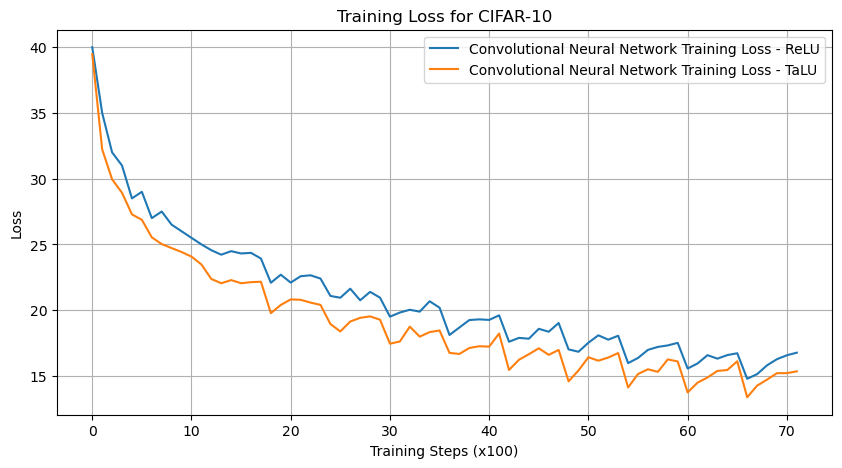

In [168]:
# Vizualize CIFAR-10 CNN ReLU versus TaLU

Shifted_Net_ReLU_train_losses = [40,35,32,31,28.5,29,27,27.5,26.5,26,25.5,25] + Net_ReLU_train_losses

plt.figure(figsize=(10, 5))
plt.plot(Shifted_Net_ReLU_train_losses, label='Convolutional Neural Network Training Loss - ReLU')
plt.plot(Net_TaLU_train_losses, label='Convolutional Neural Network Training Loss - TaLU')
plt.title('Training Loss for CIFAR-10')
plt.xlabel('Training Steps (x100)')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

#### Vizualize CIFAR-10 CNN ReLU vs TaLU

<center><img src="assets/CIFAR-10-ReLU-TaLU.jpg" alt="CNN for CIFAR-10: ReLU vs TaLU" align="center" width="720"/></center>

Initial results are more promising than the MNIST experients with **TaLU** outperforming **ReLU**.